### Import needed packets 

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline


In [94]:
#Training data
train_df = pd.read_csv("train.csv")
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [95]:
#testing data
test_df = pd.read_csv("test.csv")
test_df.head()


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Data overviews


As we can clearly see, there is one less columns at the test set. Column "Survived"

In [96]:
print(train_df.shape)
print(test_df.shape)

(891, 12)
(418, 11)


Checking if there are any Na values. As the result, there are some missing values in "Age", "Cabin" and "Embarked"

In [97]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

For test set, there are some missing values in "Age", "Cabin" and "Embarked" and "Fare"

In [98]:
test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [99]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


#### Function that build a stacked bar for visualization 

In [100]:
def chart(dataset):
    survived = train_df[train_df["Survived"]==1][dataset].value_counts()
    death = train_df[train_df["Survived"]==0][dataset].value_counts()
    df = pd.DataFrame([survived,death])
    df.index=["Survive","Dead"]
    ax= df.plot(kind="bar", stacked=True,figsize=(8,5))
    
    for rect in ax.patches:
    # Find where everything is located
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()

        # The height of the bar is the data value and can be used as the label
        label_text = f'{height}'  # f'{height:.2f}' to format decimal values

        # ax.text(x, y, text)
        label_x = x + width - 0.2  # adjust 0.2 to center the label
        label_y = y + height / 2
        ax.text(label_x, label_y, label_text, ha='right', va='center', fontsize=8)
        
    plt.show()

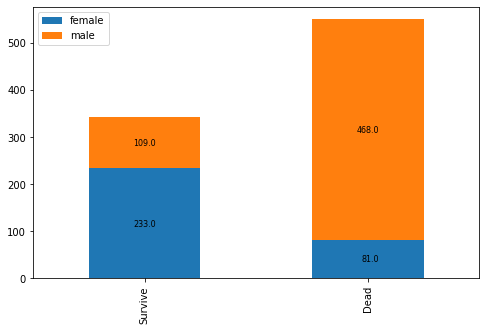

In [101]:
chart("Sex")

Women more likely survived than Men

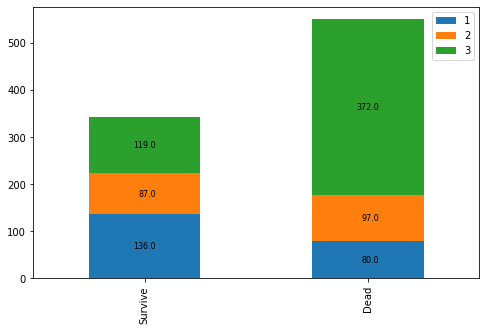

In [102]:
chart("Pclass")

People in **1st** class are more likely to survived than other <br>
People in **3rd** class are more likely to dead than other

### Explorer SibSp and Parch

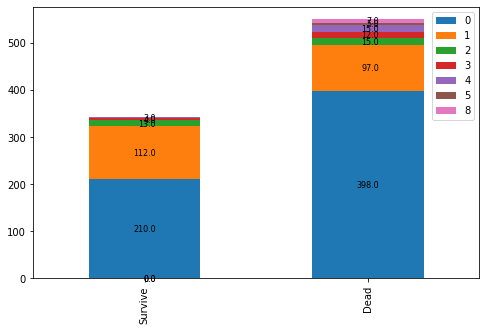

In [103]:
chart("SibSp")

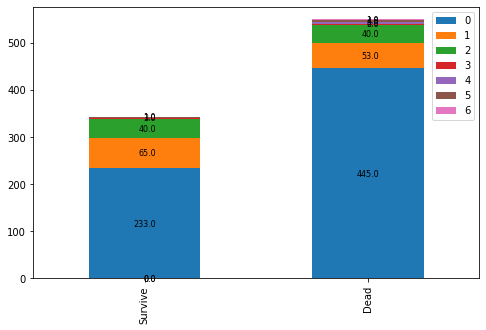

In [104]:
chart("Parch")

It hard to tell any thing from this bar chart. Therefore, I will using factor plot from seabon library to explore more about the survival possibility of each factor

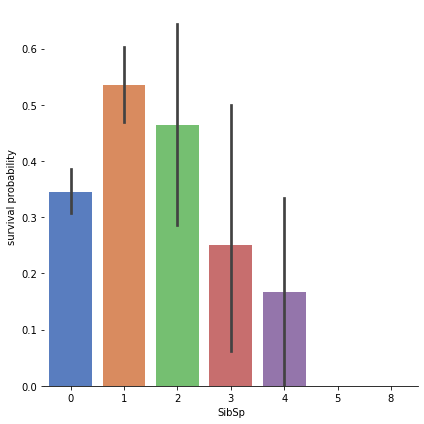

In [105]:
# Explore SibSp feature vs Survived
g = sns.factorplot(x="SibSp",y="Survived",data=train_df,kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

As a result, people who single or  on board with 1 or 2 Siblings/spouses were having high chance to survived than other.

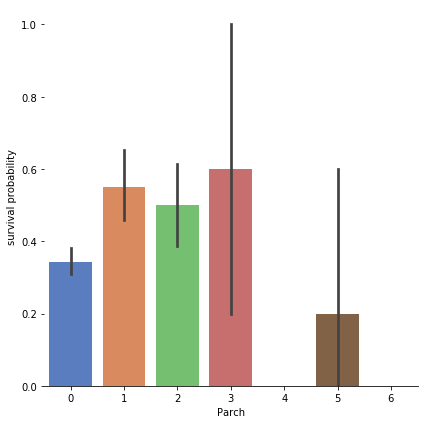

In [106]:
# Explore Parch feature vs Survived
g  = sns.factorplot(x="Parch",y="Survived",data=train_df,kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

Small families have more chance to survive, more than single (Parch 0), medium (Parch 3,4) and large families (Parch 5,6 ). <br>
There is  large stander deviation in a family of 4 

## Dealing with missing values and Feature Engineering
At this steps, I will try to fill in missing entries with some meaningful values and then create features (feature vectors) that make machine learning algorithms work.

In [107]:
# combining train and test dataset
train_test_df = [train_df,test_df]
len(train_test_df)

2

### Age
For the purpose of filling missing value, in this case, the age values, I will focusing on the title of each person since each of them will have one. Base of their title, I will fill in the missing values "Age" by using the median values of each group of Title. 

In [108]:
for data in train_test_df:
    data["Title"]=data["Name"].str.extract(" ([a-zA-Z]+)\.")
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [109]:
print("There are {} unique Titles in the training data set".
      format(len(train_df["Title"].unique())))
train_df["Title"].value_counts()

There are 17 unique Titles in the training data set


Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Col           2
Mlle          2
Ms            1
Don           1
Jonkheer      1
Sir           1
Mme           1
Lady          1
Countess      1
Capt          1
Name: Title, dtype: int64

As the result, theres are total 17 different group of title in the training dataset. By grouping both train and test dataset by "Title" and take the median age values of each group, I am filling the nan values of "Age" column for each set

In [110]:
train_df["Age"].fillna(train_df.groupby("Title")["Age"].transform('median'),inplace=True)
test_df["Age"].fillna(train_df.groupby("Title")["Age"].transform('median'),inplace=True)

In [111]:
#Double check there is no nan values in "Age"
print(train_df["Age"].isnull().sum())
print(test_df["Age"].isnull().sum())

0
0


#### Visualize the "Age" data

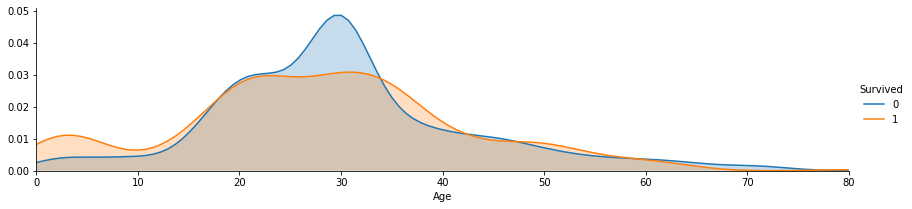

In [112]:
facet = sns.FacetGrid(train_df, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train_df['Age'].max()))
facet.add_legend()
plt.show()

Looking at the above graph, people age range from 0 (infant) to 80 years olds. There is a long ranges. Therefore we can using binning method to convert numerical Age to Categorical Variable.
<br>
There are: 
<li> Children: 0-->12 ==> 0 </li>
<li> Teen/Young Adult: 13-->21 ==> 1 </li>
<li> Adult : 22-->50 ==> 2 </li>
<li> Senior: 51 --> above ==> 3 </li>

In [113]:
#Bin age
for dataset in train_test_df:
    dataset.loc[dataset["Age"]<=12,'Age']=0 #Child
    dataset.loc[(dataset["Age"]>12) & (dataset["Age"]<=21),"Age"]=1 #Teen/Young Adult
    dataset.loc[(dataset["Age"]>21) & (dataset["Age"]<=50),"Age"]=2 # Adult
    dataset.loc[dataset["Age"]>50,"Age"]=3 #Senior 

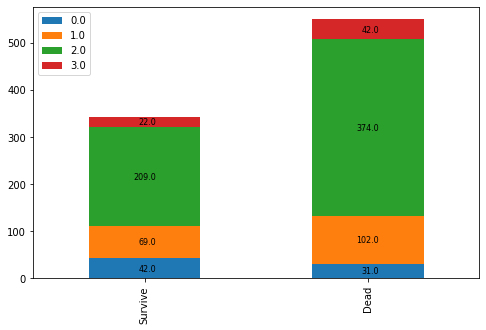

In [114]:
chart("Age")

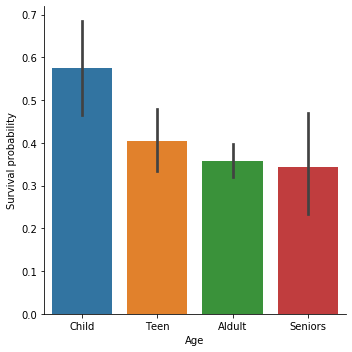

In [115]:
p= sns.factorplot(x="Age",y="Survived",data=train_df,kind="bar")
p= p.set_xticklabels(["Child","Teen","Aldult","Seniors"])
p= p.set_ylabels("Survival probability")

The result clearly shows that younger passengers has higher change to survived.

### Embarked
Port of Embarkation. 
Base on the data information, there are 3 ports:
<li>C = Cherbourg,</li>
<li>Q = Queenstown,</li>
<li>S = Southampton</li>

In [116]:
print(train_df["Embarked"].isnull().sum())
print(test_df["Embarked"].isnull().sum())

2
0


In [117]:
train_df["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Since there are only 2 missing values on the training set, I just going to fill in the values with the most frequent value of "Embarked" (S). Then, for the purpose of feature engineering, I also map the values to numerical value 
<li> S = 0 </li>
<li> C = 1 </li>
<li> Q = 2 </li>

In [118]:
for dataset in train_test_df:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    dataset["Embarked"]=dataset["Embarked"].map({"S":0,"C":1,"Q":2})

In [119]:
#Double check
print(train_df["Embarked"].isnull().sum())
train_df["Embarked"].value_counts()

0


0    646
1    168
2     77
Name: Embarked, dtype: int64

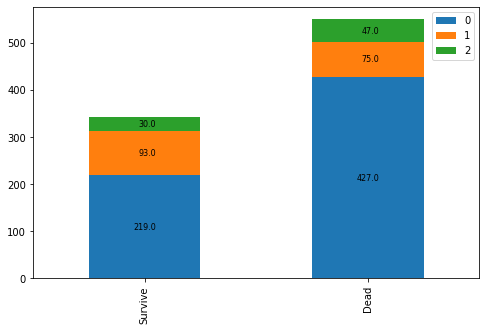

In [120]:
chart("Embarked")

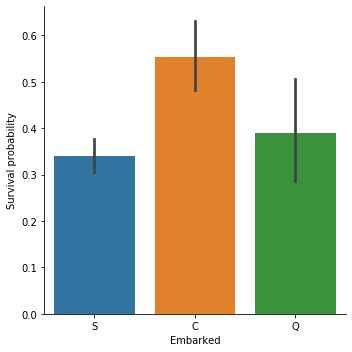

In [121]:
p= sns.factorplot(x="Embarked",y="Survived",data=train_df,kind="bar")
p= p.set_xticklabels(["S","C","Q"])
p= p.set_ylabels("Survival probability")

As the result, people who departed from Cherbourg had higher survival chance.

### Titles
For this feature, we are going to see if we could see how the title, will contribute on their survival since during the evacuation, distinguished title may have the priority.   


As the result above, we can see that there are totally 17 unique titles, but some of them are less popular, some only has 1 value. Therefore we can group them as a same group and mapping them with its corresponding numerical values.

<li> Mr:0</li>
<li>Miss/Mrs/Mme/Ms/Mlle:1</li>
<li>Master:2</li>
<li>Other:3</li>
    

In [122]:
for data in train_test_df:
    data["Title"]=data["Title"].replace(['Lady','Countess','Capt', 
                                'Col','Don', 'Dr', 'Major', 
                                'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other')
    data["Title"]=data["Title"].map({"Mr":0,
                                     "Miss":1,"Mrs":1,"Mme":1,"Ms":1,"Mlle":1,
                                     "Master":2,
                                     "Other":3
                                    })
    
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,2.0,1,0,A/5 21171,7.2500,NaN,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,2.0,1,0,PC 17599,71.2833,C85,1,1
2,3,1,3,"Heikkinen, Miss. Laina",female,2.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,2.0,1,0,113803,53.1000,C123,0,1
4,5,0,3,"Allen, Mr. William Henry",male,2.0,0,0,373450,8.0500,NaN,0,0


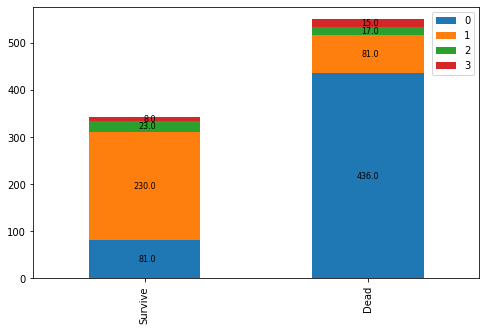

In [123]:
chart("Title")

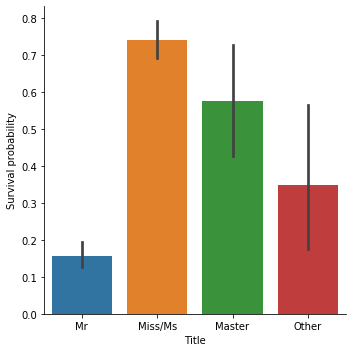

In [124]:
p= sns.factorplot(x="Title",y="Survived",data=train_df,kind="bar")
p= p.set_xticklabels(["Mr","Miss/Ms","Master","Other"])
p= p.set_ylabels("Survival probability")

As the result, we could see that people with their title of Miss/Mrs/Ms and Master have a high chance of survive than other. 

In [125]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,2.0,1,0,A/5 21171,7.2500,NaN,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,2.0,1,0,PC 17599,71.2833,C85,1,1
2,3,1,3,"Heikkinen, Miss. Laina",female,2.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,2.0,1,0,113803,53.1000,C123,0,1
4,5,0,3,"Allen, Mr. William Henry",male,2.0,0,0,373450,8.0500,NaN,0,0


### Family
As this feature, I am going to combine "SibSb" and "Parch" together and then group them into different group based on the size of each family.
<li>Single</li>
<li>SmallFam</li>
<li>MediumFam</li>
<li>LargeFam</li>

In [126]:
train_df["FamilySize"] = train_df["SibSp"] + train_df["Parch"] + 1
test_df["FamilySize"] = test_df["SibSp"] + test_df["Parch"] + 1

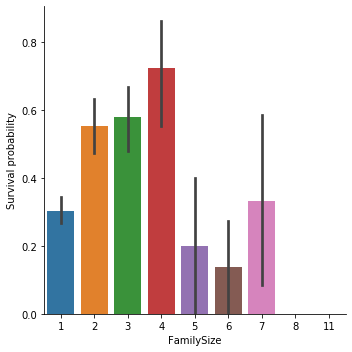

In [127]:
p = sns.factorplot(x="FamilySize", y= "Survived", data=train_df,kind="bar")
#p= p.set_xticklabels(["0","Te","Aldult","Seniors"])
p= p.set_ylabels("Survival probability")

People with number of 4 members in their family has higher chance to survive compare to other.

#### One-Hot Encoding Family size
Family size seems to plays an important factor for our analysis, therefore, for the purpose of feature engineer, I will using one-hot encoding method to split family size into different categories, Single, SmallFam, MediumFam, and LargeFam


In [128]:
for dataset in train_test_df:
    dataset["Single"]=dataset["FamilySize"].map(lambda x:1 if x ==1 else 0)
    dataset["SmallFam"]=dataset["FamilySize"].map(lambda x:1 if x ==2  else 0)
    dataset["MediumFam"]=dataset["FamilySize"].map(lambda x:1 if 3<=x <=4 else 0)
    dataset["LargFam"]=dataset["FamilySize"].map(lambda x:1 if x >=5 else 0)

In [129]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,Single,SmallFam,MediumFam,LargFam
0,1,0,3,"Braund, Mr. Owen Harris",male,2.0,1,0,A/5 21171,7.2500,NaN,0,0,2,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,2.0,1,0,PC 17599,71.2833,C85,1,1,2,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,2.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1,1,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,2.0,1,0,113803,53.1000,C123,0,1,2,0,1,0,0
4,5,0,3,"Allen, Mr. William Henry",male,2.0,0,0,373450,8.0500,NaN,0,0,1,1,0,0,0


### Fare
Passenger fare
<br>
Apply binning method for Fare

In [130]:
print(train_df["Fare"].isnull().sum())
print(test_df["Fare"].isnull().sum())


0
1


There is only one missing value in test_df. We can just using the median value to fill in and it will not have big effect on our result. However, I think there is a relationship between Pcclass and Fare, therefore I use group them as Pclass and take median Fare from each class. I think the fare will be more accurate.

In [131]:
test_df["Fare"].fillna(test_df.groupby("Pclass")["Fare"].transform('median'),inplace=True)

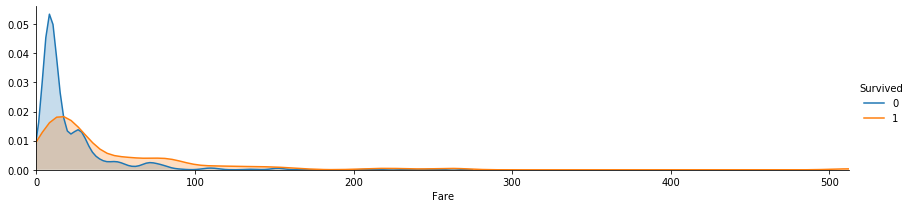

In [132]:
facet = sns.FacetGrid(train_df, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Fare',shade= True)
facet.set(xlim=(0, train_df['Fare'].max()))
facet.add_legend()
plt.show()

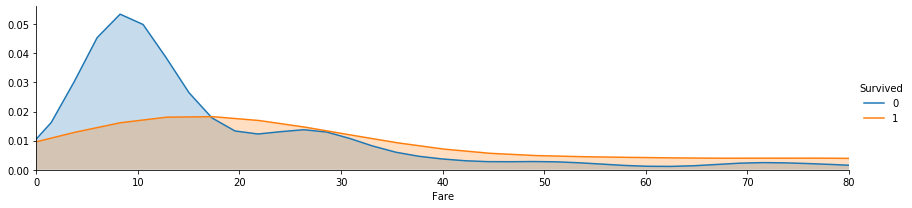

In [133]:
facet = sns.FacetGrid(train_df, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Fare',shade= True)
facet.set(xlim=(0, 80))
facet.add_legend()
plt.show()

In [134]:
#Bin Fare
for dataset in train_test_df:
    dataset.loc[dataset["Fare"]<=17,'Fare']=0 
    dataset.loc[(dataset["Fare"]>17) & (dataset["Fare"]<=30),"Fare"]=1 
    dataset.loc[(dataset["Fare"]>30) & (dataset["Fare"]<=80),"Fare"]=2 
    dataset.loc[dataset["Fare"]>80,"Fare"]=3   

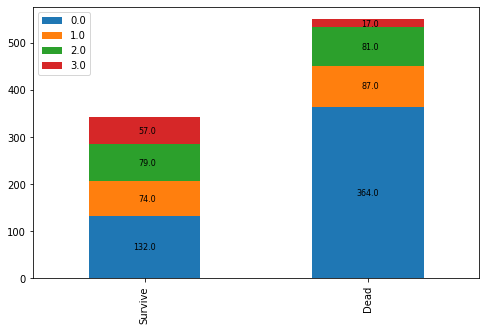

In [135]:
chart("Fare")

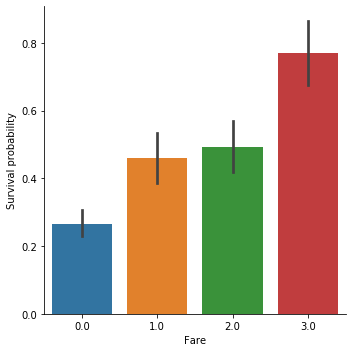

In [136]:
p = sns.factorplot(x="Fare", y= "Survived", data=train_df,kind="bar")
#p= p.set_xticklabels(["0","Te","Aldult","Seniors"])
p= p.set_ylabels("Survival probability")

Clearly see that,Survival probability of passengers with higher "Fare" are higher than others 

### Gender
Mapping the values form category to numerical value

In [137]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,Single,SmallFam,MediumFam,LargFam
0,1,0,3,"Braund, Mr. Owen Harris",male,2.0,1,0,A/5 21171,0.0,NaN,0,0,2,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,2.0,1,0,PC 17599,2.0,C85,1,1,2,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,2.0,0,0,STON/O2. 3101282,0.0,NaN,0,1,1,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,2.0,1,0,113803,2.0,C123,0,1,2,0,1,0,0
4,5,0,3,"Allen, Mr. William Henry",male,2.0,0,0,373450,0.0,NaN,0,0,1,1,0,0,0


In [138]:
gender_map={"female":0,"male":1}
for data in train_test_df:
    data["Sex"]=data["Sex"].map(gender_map)


In [139]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,Single,SmallFam,MediumFam,LargFam
0,1,0,3,"Braund, Mr. Owen Harris",1,2.0,1,0,A/5 21171,0.0,NaN,0,0,2,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2.0,1,0,PC 17599,2.0,C85,1,1,2,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,2.0,0,0,STON/O2. 3101282,0.0,NaN,0,1,1,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,2.0,1,0,113803,2.0,C123,0,1,2,0,1,0,0
4,5,0,3,"Allen, Mr. William Henry",1,2.0,0,0,373450,0.0,NaN,0,0,1,1,0,0,0


In [140]:
# Drop Columns
train_df.drop(["Name","Ticket","SibSp","Parch","Cabin"],1,inplace=True)
test_df.drop(["Name","Ticket","SibSp","Parch"],1,inplace=True)

In [141]:
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize,Single,SmallFam,MediumFam,LargFam
0,1,0,3,1,2.0,0.0,0,0,2,0,1,0,0
1,2,1,1,0,2.0,2.0,1,1,2,0,1,0,0
2,3,1,3,0,2.0,0.0,0,1,1,1,0,0,0
3,4,1,1,0,2.0,2.0,0,1,2,0,1,0,0
4,5,0,3,1,2.0,0.0,0,0,1,1,0,0,0


## Modeling 

In [157]:
# Importing Classifier Modules
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Cross validation (k-fold)
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [168]:
train_data = train_df.drop(["PassengerId","Survived"],1)
test_data = test_df.drop(["PassengerId","Cabin"],1)
y = train_df["Survived"]

In [169]:
print(train_data.shape)
print(y.shape)

(891, 11)
(891,)


### Cross Validation (k-fold)

In [159]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

### K-NN 

In [181]:
scoring = 'accuracy'
scores =[] 
for i in range(1,20):
    model  = KNeighborsClassifier(n_neighbors=i)
    score = cross_val_score(model, train_data, y, cv=k_fold, n_jobs=1, scoring=scoring)
    scores.append(round(np.mean(score)*100,2))

print( "The best accuracy was with", max(scores), "with k=",[i + 1 for i, j in enumerate(scores) if j == max(scores)]) 
    

The best accuracy was with 82.49 with k= [12]


### Decision Tree 

In [184]:
scores=[]
for i in range (1,20):
    model = DecisionTreeClassifier(criterion='entropy', max_depth=i)
    score =cross_val_score(model, train_data, y, cv=k_fold, n_jobs=1, scoring=scoring)
    scores.append(round(np.mean(score)*100,2))

# Desision Tree Score:
print(scores)
print( "The best accuracy was with", max(scores), "with k=",[i + 1 for i, j in enumerate(scores) if j == max(scores)]) 


[77.89, 77.1, 82.6, 82.49, 81.59, 82.6, 81.48, 80.58, 80.58, 80.81, 81.14, 80.58, 80.92, 80.92, 81.03, 80.92, 81.14, 80.81, 80.92]
The best accuracy was with 82.6 with k= [3, 6]


### SVM

In [179]:
model = SVC(gamma="auto")
score =cross_val_score(model, train_data, y, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)
#SVM scores:
print("SVM Score: ", round(np.mean(score)*100,2))

[0.84444444 0.80898876 0.82022472 0.82022472 0.84269663 0.80898876
 0.82022472 0.84269663 0.83146067 0.86516854]
SVM Score:  83.05


### Random Forest

In [185]:
scores=[]
for i in range (1,20):
    model = RandomForestClassifier(n_estimators=i)
    score =cross_val_score(model, train_data, y, cv=k_fold, n_jobs=1, scoring=scoring)
    scores.append(round(np.mean(score)*100,2))

# Random Forest Score:
print(scores)
print( "Random forest score: ", max(scores), "with k=",[i + 1 for i, j in enumerate(scores) if j == max(scores)]) 


[81.37, 80.8, 80.81, 81.59, 81.25, 81.37, 81.7, 81.48, 81.48, 82.04, 81.7, 82.6, 81.59, 82.26, 82.04, 82.6, 81.82, 82.15, 81.82]
Random forest score:  82.6 with k= [12, 16]


### Naive Bayes

In [186]:
model = GaussianNB()
score =cross_val_score(model, train_data, y, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)
#Naive Bayes:
print("Naive Bayes: ", round(np.mean(score)*100,2))

[0.8        0.75280899 0.71910112 0.75280899 0.78651685 0.80898876
 0.78651685 0.7752809  0.82022472 0.83146067]
Naive Bayes:  78.34


#### As the result, I will chose SVM as my final model  for the test set

In [188]:
model = SVC(gamma="auto")
model.fit(train_data,y)
result = model.predict(test_data)


array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [191]:
submission = pd.DataFrame({
    "PassengerId": test_df["PassengerId"],
    "Survived": result
})

submission.to_csv("submission.csv",index= False)

In [192]:
re = pd.read_csv("submission.csv")
re.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
